In [128]:
import nibabel as nib
import nipy as nipy
import matplotlib.pyplot as plt
import nipype.algorithms.rapidart as rpd    # rapidart module
import nipype.interfaces.io as nio          # Data i/o
import nipype.interfaces.fsl as fsl         # fsl
import nipype.interfaces.utility as util    # utility
import nipype.pipeline.engine as pe         # pypeline engine
import numpy as np
import os, sys
from tqdm import tqdm
import time
import pandas as pd
from scipy.stats import ttest_ind, mannwhitneyu, pearsonr
import seaborn as sns

In [2]:
# Sorts data into dictionary and returns dictionary
def findFileLocations():
    subjDict = {}
    dataDir = "/data/subjects"
    for subj in os.listdir(dataDir):
        if subj.isdigit():
            fetalFol = subj + "_fetal"
            neonateFol = subj + "_neonate" 
            fetalDir = os.path.join(dataDir, subj, fetalFol)
            fetalMask = None
            fetalTemplate = None
            for file in os.listdir(fetalDir):
                if "mask" in file:
                    fetalMask = os.path.join(fetalDir, file)
                elif "template" in file or "recon" in file:
                    fetalTemplate = os.path.join(fetalDir, file)
            outputsFol = None
            outputNum = None
            neonateDir = os.path.join(dataDir, subj, neonateFol)
            for folder in os.listdir(neonateDir):
                if "Outputs" in folder:
                    outputsFol = os.path.join(neonateDir, folder)
                    outputNum = int(folder[7])
                    break
            neonateDir = os.path.join(outputsFol, "T2_Bias_Corrected")
            neonateFile = None
            for file in os.listdir(neonateDir):
                neonateFile = os.path.join(neonateDir, file)
            subjDict[subj] = (fetalTemplate, fetalMask, neonateFile, outputNum)
    return subjDict

In [84]:
def findResults():
    subjDict = findFileLocations()
    resultDict = {}
    dataDir = "/data/subjects"
    for subj in os.listdir(dataDir):
        if subj.isdigit():
            outputsFol = subj + "_outputs"
            outputsDir = os.path.join(dataDir, subj, outputsFol)
            similarity = None
            for output in os.listdir(outputsDir):
                if output == "similar.txt":
                    with open(os.path.join(outputsDir, output), "r") as f:
                        similarity = 1 - float(f.read())
            timePoint = subjDict[subj][3]
            resultDict[subj] = (similarity, timePoint)
    return resultDict

In [85]:
resultDict = findResults()
for subj in resultDict:
    if subj[0] == "0":
        newSubj = subj[1:]
        resultDict[newSubj] = resultDict[subj]
        del resultDict[subj]
for subj in resultDict:
    if subj[0] == "0":
        newSubj = subj[1:]
        resultDict[newSubj] = resultDict[subj]
        del resultDict[subj]
for subj in resultDict:
    if isinstance(subj, str):
        resultDict[int(subj)] = resultDict[subj]
        del resultDict[subj]
resultDf = pd.DataFrame.from_dict(resultDict, orient="index", columns=["similarity_value", "timepoint"])
resultDf.to_excel("/data/similarity_results_2023-7-25.xlsx", header=True, index=True)
resultDf.reset_index(inplace=True)
resultDf.rename(columns={"index":"PIRC_ID"}, inplace=True)
resultDf

,PIRC_ID,similarity_value,timepoint
0,305,0.088970,1
1,313,0.313827,1
2,324,0.254317,1
3,434,0.336365,2
4,455,0.256013,1
...,...,...,...
64,35,0.102436,1
65,49,0.376762,1
66,97,0.248226,1
67,6,0.295795,1


In [86]:
demoDf = pd.read_excel("/data/Cleaned_subject_demographic_data_2023-07-25.xlsx", engine="openpyxl")
demoDf

,PIRC_ID,CHD_status,neonate_age_yrs,neonate_timepoint,neonate_age_wks,fetal_ga_wks,time_duration_bt_fet_neo_wks
0,382,CHD,0.090,1,4.68,29.285714,15.39
1,382,CHD,0.164,2,8.53,29.285714,19.24
2,382,CHD,0.548,3,28.50,29.285714,39.21
3,382,CHD,2.047,4,106.44,29.285714,117.15
4,382,CHD,2.321,5,120.69,29.285714,131.40
...,...,...,...,...,...,...,...
304,1400,CON,NaN,0,NaN,NaN,NaN
305,1401,CON,NaN,0,NaN,NaN,NaN
306,1402,CON,NaN,0,NaN,NaN,NaN
307,1408,CON,NaN,0,NaN,NaN,NaN


In [123]:
resultDf['PIRC_ID'] = resultDf['PIRC_ID'].astype(int)
demoDf['PIRC_ID'] = demoDf['PIRC_ID'].astype(int)
df = pd.merge(resultDf, demoDf, left_on=["PIRC_ID", "timepoint"], right_on=["PIRC_ID", "neonate_timepoint"], how="left")
df.groupby("CHD_status").mean()

,PIRC_ID,similarity_value,timepoint,neonate_age_yrs,neonate_timepoint,neonate_age_wks,fetal_ga_wks,time_duration_bt_fet_neo_wks
CHD_status,,,,,,,,
CHD,607.450000,0.295411,1.350000,0.141700,1.350000,7.369000,33.402143,13.967000
CON,697.795918,0.337431,1.061224,0.200531,1.061224,10.427959,31.983673,18.444082


In [124]:
df[df["neonate_age_wks"] > 52]

,PIRC_ID,similarity_value,timepoint,CHD_status,neonate_age_yrs,neonate_timepoint,neonate_age_wks,fetal_ga_wks,time_duration_bt_fet_neo_wks
23,1156,0.258194,2,CON,1.247,2,64.84,37.285714,67.55
33,231,0.238092,6,CHD,1.208,6,62.82,30.142857,72.68


In [125]:
df[df["time_duration_bt_fet_neo_wks"] > 60]
df = df[df["time_duration_bt_fet_neo_wks"] < 60].copy()
df

,PIRC_ID,similarity_value,timepoint,CHD_status,neonate_age_yrs,neonate_timepoint,neonate_age_wks,fetal_ga_wks,time_duration_bt_fet_neo_wks
0,305,0.088970,1,CON,0.099,1,5.15,29.000000,16.15
1,313,0.313827,1,CON,0.184,1,9.57,34.000000,15.57
2,324,0.254317,1,CON,0.192,1,9.98,31.285714,18.69
3,434,0.336365,2,CON,0.170,2,8.84,33.000000,15.84
4,455,0.256013,1,CHD,0.197,1,10.24,33.000000,17.24
...,...,...,...,...,...,...,...,...,...
64,35,0.102436,1,CHD,0.011,1,0.57,35.000000,5.57
65,49,0.376762,1,CON,0.140,1,7.28,30.000000,17.28
66,97,0.248226,1,CON,0.178,1,9.26,32.000000,17.26
67,6,0.295795,1,CON,0.148,1,7.70,38.000000,9.70


In [89]:
chd = df[df["CHD_status"]=="CHD"]
con = df[df["CHD_status"]=="CON"]

In [126]:
print(str(len(chd)), str(len(con)))

19 48


In [90]:
chd

,PIRC_ID,similarity_value,timepoint,CHD_status,neonate_age_yrs,neonate_timepoint,neonate_age_wks,fetal_ga_wks,time_duration_bt_fet_neo_wks
4,455,0.256013,1,CHD,0.197,1,10.24,33.000000,17.24
5,465,0.077227,1,CHD,0.008,1,0.42,32.000000,8.42
9,744,0.391364,1,CHD,0.005,1,0.26,35.000000,5.26
10,752,0.435164,1,CHD,0.351,1,18.25,37.428571,20.82
18,1053,0.410120,1,CHD,0.008,1,0.42,35.900000,4.52
21,1081,0.175948,1,CHD,0.115,1,5.98,36.428571,9.55
28,129,0.258095,2,CHD,0.014,2,0.73,28.571429,12.16
29,136,0.176149,1,CHD,0.011,1,0.57,36.714286,3.86
30,138,0.152493,1,CHD,0.019,1,0.99,37.000000,3.99
31,208,0.500359,1,CHD,0.173,1,9.00,36.857143,12.14


In [91]:
con

,PIRC_ID,similarity_value,timepoint,CHD_status,neonate_age_yrs,neonate_timepoint,neonate_age_wks,fetal_ga_wks,time_duration_bt_fet_neo_wks
0,305,0.088970,1,CON,0.099,1,5.15,29.000000,16.15
1,313,0.313827,1,CON,0.184,1,9.57,34.000000,15.57
2,324,0.254317,1,CON,0.192,1,9.98,31.285714,18.69
3,434,0.336365,2,CON,0.170,2,8.84,33.000000,15.84
6,488,0.314928,1,CON,0.112,1,5.82,32.000000,13.82
7,660,0.303033,1,CON,0.173,1,9.00,29.000000,20.00
8,691,0.301926,1,CON,0.118,1,6.14,28.000000,18.14
11,753,0.237465,1,CON,0.260,1,13.52,27.000000,26.52
12,754,0.291363,1,CON,0.162,1,8.42,30.000000,18.42
13,756,0.245564,1,CON,0.321,1,16.69,29.000000,27.69


(0.08995898092791435, 0.7141820546172472)
(0.6102279276609026, 4.126889423153645e-06)


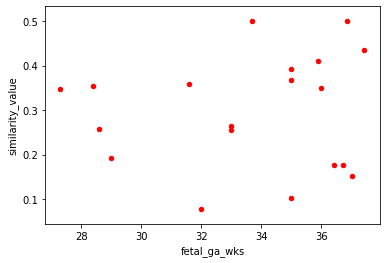

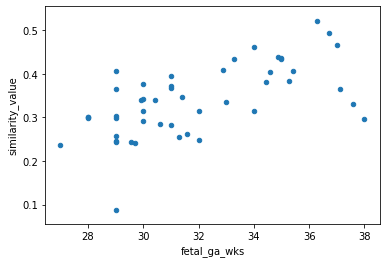

In [92]:
# print("CHD fetal age (wks) vs. similarity value, pearson = " + str(chd["fetal_ga_wks"].corr(df["similarity_value"])) + " (weak negative rel)")
res = pearsonr(chd["fetal_ga_wks"], (chd["similarity_value"]))
print(res)
chd.plot.scatter(x="fetal_ga_wks", y="similarity_value", color="red");
# print("CON fetal age (wks) vs. similarity value, pearson = " + str(con["fetal_ga_wks"].corr(df["similarity_value"])) + " (strong negative rel)")
res = pearsonr(con["fetal_ga_wks"], (con["similarity_value"]))
print(res)
con.plot.scatter(x="fetal_ga_wks", y="similarity_value");

(0.232437278858281, 0.3382690708056175)
(-0.1356789058437204, 0.35783708676391157)


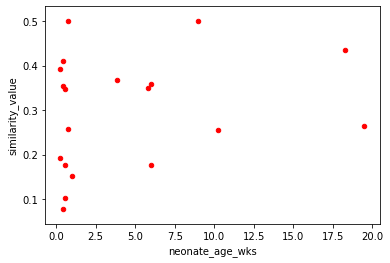

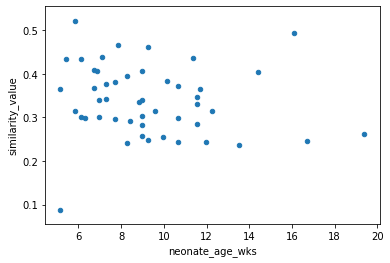

In [93]:
### print("CHD neonatal age (wks) vs. similarity value, pearson = " + str(chd["neonate_age_wks"].corr(df["similarity_value"])) + " (weak positive rel)")
res = pearsonr(chd["neonate_age_wks"], (chd["similarity_value"]))
print(res)
chd.plot.scatter(x="neonate_age_wks", y="similarity_value", color="red");
# print("CON neonatal age (wks) vs. similarity value, pearson = " + str(con["neonate_age_wks"].corr(df["similarity_value"])) + " (weak positive rel)")
res = pearsonr(con["neonate_age_wks"], (con["similarity_value"]))
print(res)
con.plot.scatter(x="neonate_age_wks", y="similarity_value");

(0.23233390802449566, 0.33849005056597997)
(-0.13556018455541632, 0.358261822686128)


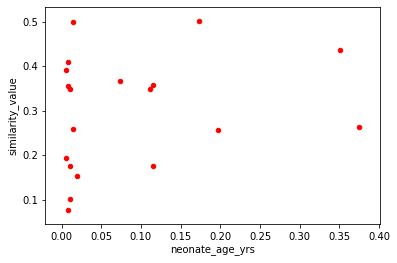

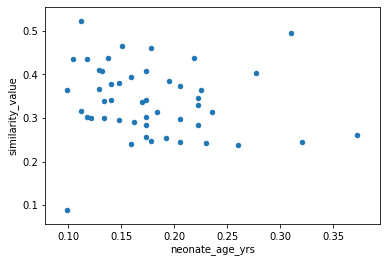

In [94]:
# print("CHD neonatal age (yrs) vs. similarity value, pearson = " + str(chd["neonate_age_yrs"].corr(df["similarity_value"])) + " (weak positive rel)")
res = pearsonr(chd["neonate_age_yrs"], (chd["similarity_value"]))
print(res)
chd.plot.scatter(x="neonate_age_yrs", y="similarity_value", color="red");
# print("CON neonatal age (yrs) vs. similarity value, pearson = " + str(con["neonate_age_yrs"].corr(df["similarity_value"])) + " (weak positive rel)")
res = pearsonr(con["neonate_age_yrs"], (con["similarity_value"]))
print(res)
con.plot.scatter(x="neonate_age_yrs", y="similarity_value");

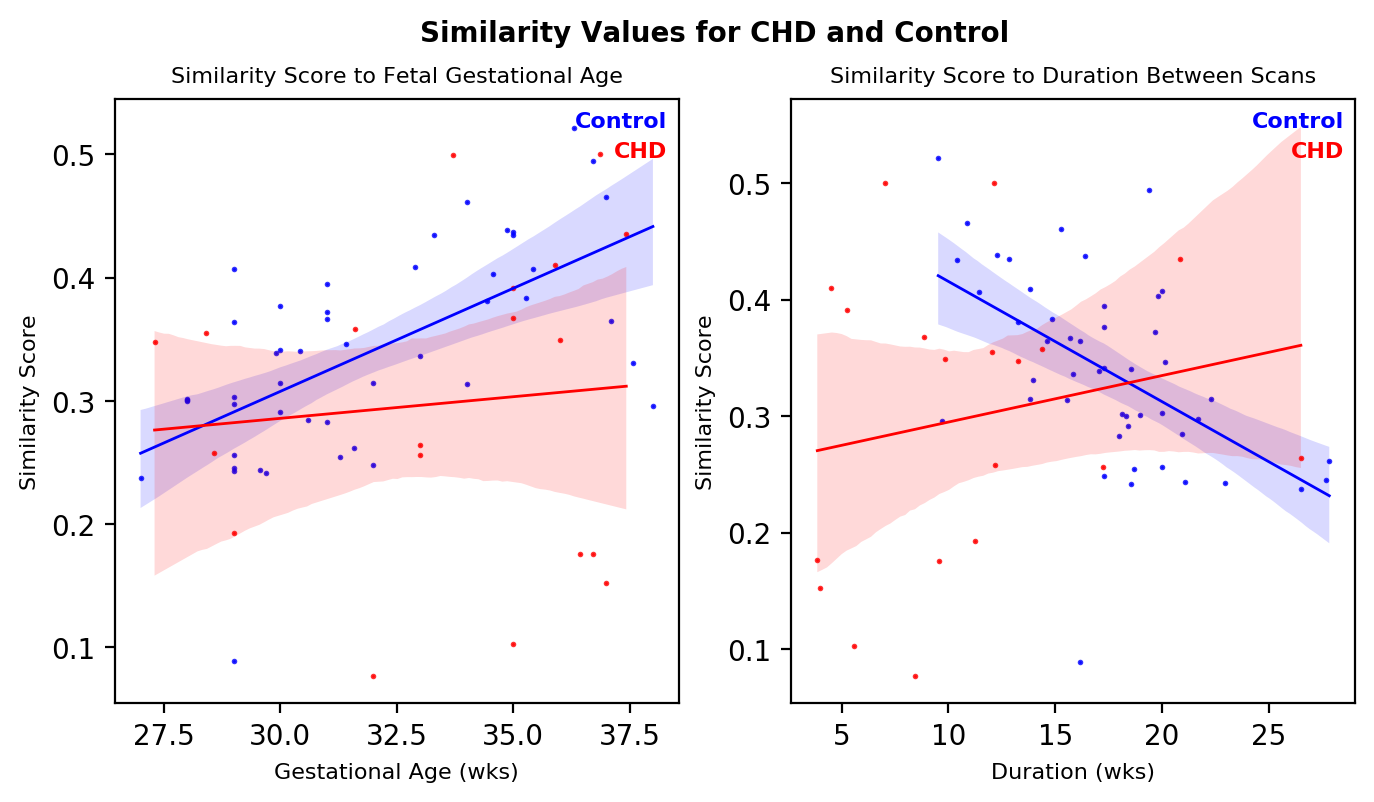

In [133]:
column = 'fetal_ga_wks'
res_chd = pearsonr(chd[column], (chd["similarity_value"]))
res_con = pearsonr(con[column], (con["similarity_value"]))

fig, axes = plt.subplots(1,2, facecolor = 'white', dpi = 200, figsize = (8,4))
fig.suptitle('Similarity Values for CHD and Control', fontsize = 10, fontweight ='bold')
top = 0.98
step = 0.05
for enum,  (temp_df, color, res_object, chd_status) in enumerate(zip([con, chd], ['blue', 'red'], [res_con,res_chd], ['Control', 'CHD'])):
    sns.regplot(x=temp_df[column], y=temp_df['similarity_value'], color = color, scatter_kws = {'s':1}, line_kws = {'linewidth':1}, ax = axes[0])
    #axes[0].scatter(x=temp_df[column], y=temp_df['similarity_value'], color = color, s = 1)
    #axes[0].set_title(f'Correlation: {res_object[0]:>.2f}, p-value: {res_object[1]:>.2f}', fontsize = 8)
    y_loc = top-enum*step
    axes[0].text(.98, y_loc, chd_status, color = color, fontweight ='bold', fontsize= 8, transform = axes[0].transAxes, ha = 'right', va = 'top')
    axes[0].set_xlabel('Gestational Age (wks)', fontsize = 8)
    axes[0].set_ylabel('Similarity Score', fontsize = 8)

column = 'time_duration_bt_fet_neo_wks'
res_chd = pearsonr(chd[column], (chd["similarity_value"]))
res_con = pearsonr(con[column], (con["similarity_value"]))
for enum,  (temp_df, color, res_object, chd_status) in enumerate(zip([con, chd], ['blue', 'red'], [res_con,res_chd], ['Control', 'CHD'])):
    sns.regplot(x=temp_df[column], y=temp_df['similarity_value'], color = color, scatter_kws = {'s':1}, line_kws = {'linewidth':1}, ax = axes[1])
    #axes[1].scatter(x=temp_df[column], y=temp_df['similarity_value'], color = color, s = 1)
    #axes[1].set_title(f'Correlation: {res_object[0]:>.2f}, p-value: {res_object[1]:>.2f}', fontsize = 8)
    y_loc = top-enum*step
    axes[1].text(.98, y_loc, chd_status, color = color, fontweight ='bold', fontsize= 8, transform = axes[1].transAxes, ha = 'right', va = 'top')
    axes[1].set_xlabel('Duration (wks)', fontsize = 8)
    axes[1].set_ylabel('Similarity Score', fontsize = 8)
    
    
axes[0].set_title('Similarity Score to Fetal Gestational Age', fontsize = 8)
axes[1].set_title('Similarity Score to Duration Between Scans', fontsize = 8)
figure_dir = '/data/figures'
os.makedirs(figure_dir, exist_ok = True)

figure_title = 'multiple_figure_control_chd.png'
save_path = os.path.join(figure_dir, figure_title)

plt.savefig(save_path, bbox_inches = 'tight', dpi = fig.dpi)
plt.show()

In [95]:
chd["time_duration_bt_fet_neo_wks"].corr(chd["similarity_value"])

0.18565780131829512

In [96]:
pearsonr(chd["time_duration_bt_fet_neo_wks"], (chd["similarity_value"]))

(0.18565780131829512, 0.4466712226279235)

(0.18565780131829512, 0.4466712226279235)
(-0.531980900831713, 9.968477623209611e-05)


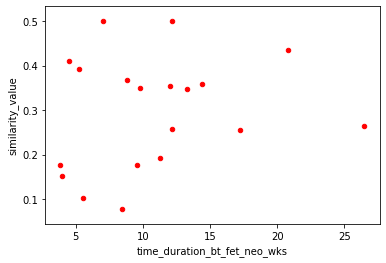

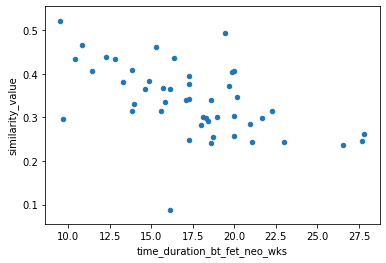

In [97]:
# print("time duration (wks) vs. similarity value, pearson = " + str(chd["time_duration_bt_fet_neo_wks"].corr(chd["similarity_value"])) + " (weak positive rel)")
res = pearsonr(chd["time_duration_bt_fet_neo_wks"], (chd["similarity_value"]))
print(res)
chd.plot.scatter(x="time_duration_bt_fet_neo_wks", y="similarity_value", color="red");
# print("time duration (wks) vs. similarity value, pearson = " + str(con["time_duration_bt_fet_neo_wks"].corr(con["similarity_value"])) + " (weak positive rel)")
res = pearsonr(con["time_duration_bt_fet_neo_wks"], (con["similarity_value"]))
print(res)
con.plot.scatter(x="time_duration_bt_fet_neo_wks", y="similarity_value");

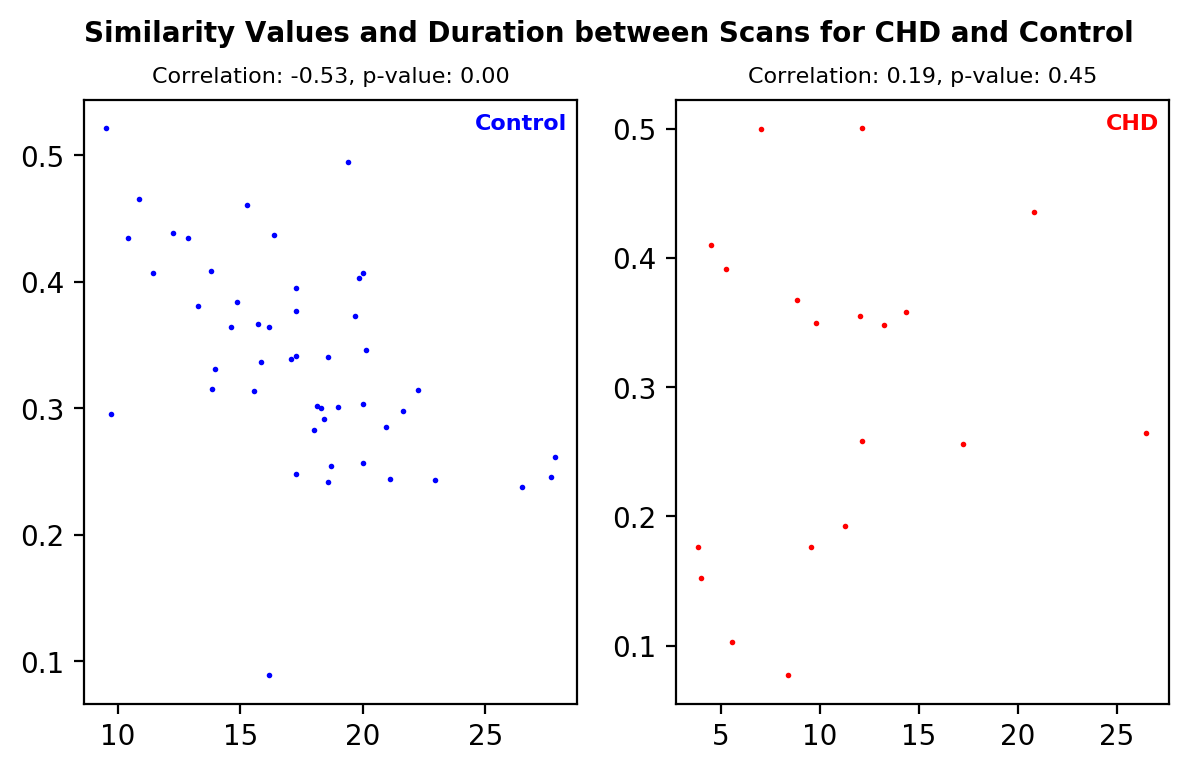

In [115]:
# generating pearson coefficient
test_column = "time_duration_bt_fet_neo_wks"
res_chd = pearsonr(chd[test_column], (chd["similarity_value"]))
res_con = pearsonr(con[test_column], (con["similarity_value"]))

fig, axes = plt.subplots(1,2, facecolor = 'white', dpi = 200, figsize = (7,4))
# set title
fig.suptitle('Similarity Values and Duration between Scans for CHD and Control', fontsize = 10, fontweight ='bold')
for enum,  (temp_df, color, res_object, chd_status) in enumerate(zip([con, chd], ['blue', 'red'], [res_con,res_chd], ['Control', 'CHD'])):
    axes[enum].scatter(x=temp_df['time_duration_bt_fet_neo_wks'], y=temp_df['similarity_value'], color = color, s=1)
    axes[enum].set_title(f'Correlation: {res_object[0]:>.2f}, p-value: {res_object[1]:>.2f}', fontsize = 8)
    axes[enum].text(.98, .95, chd_status, color = color, fontweight ='bold', fontsize= 8, transform = axes[enum].transAxes, ha="right")

figure_dir = '/data/figures'
os.makedirs(figure_dir, exist_ok = True)

# set png name
figure_title = 'time_duration_chd_con.png'
save_path = os.path.join(figure_dir, figure_title)

plt.savefig(save_path, bbox_inches = 'tight', dpi = fig.dpi)
plt.show()

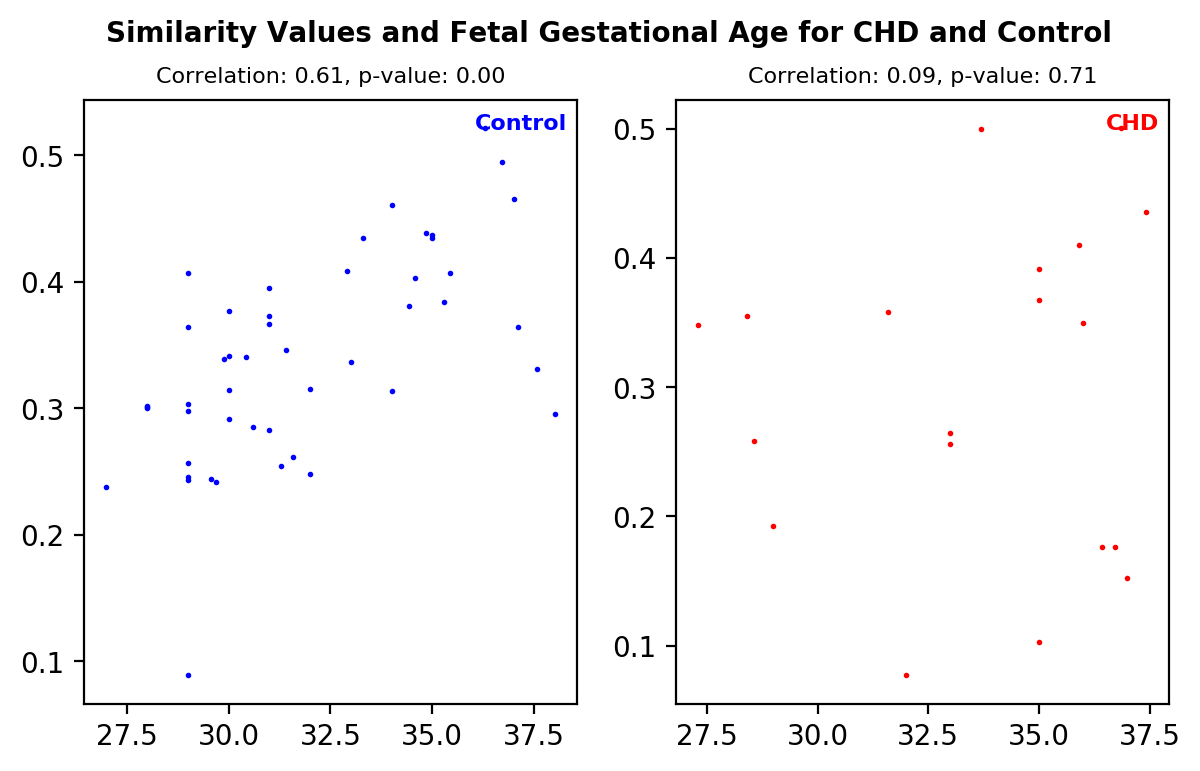

In [118]:
# generating pearson coefficient
test_column = "fetal_ga_wks"
res_chd = pearsonr(chd[test_column], (chd["similarity_value"]))
res_con = pearsonr(con[test_column], (con["similarity_value"]))

fig, axes = plt.subplots(1,2, facecolor = 'white', dpi = 200, figsize = (7,4))
# set title
fig.suptitle('Similarity Values and Fetal Gestational Age for CHD and Control', fontsize = 10, fontweight ='bold')
for enum,  (temp_df, color, res_object, chd_status) in enumerate(zip([con, chd], ['blue', 'red'], [res_con,res_chd], ['Control', 'CHD'])):
    axes[enum].scatter(x=temp_df['fetal_ga_wks'], y=temp_df['similarity_value'], color = color, s=1)
    axes[enum].set_title(f'Correlation: {res_object[0]:>.2f}, p-value: {res_object[1]:>.2f}', fontsize = 8)
    axes[enum].text(.98, .95, chd_status, color = color, fontweight ='bold', fontsize= 8, transform = axes[enum].transAxes, ha="right")

figure_dir = '/data/figures'
os.makedirs(figure_dir, exist_ok = True)

# set png name
figure_title = 'fet_age_chd_con.png'
save_path = os.path.join(figure_dir, figure_title)

plt.savefig(save_path, bbox_inches = 'tight', dpi = fig.dpi)
plt.show()

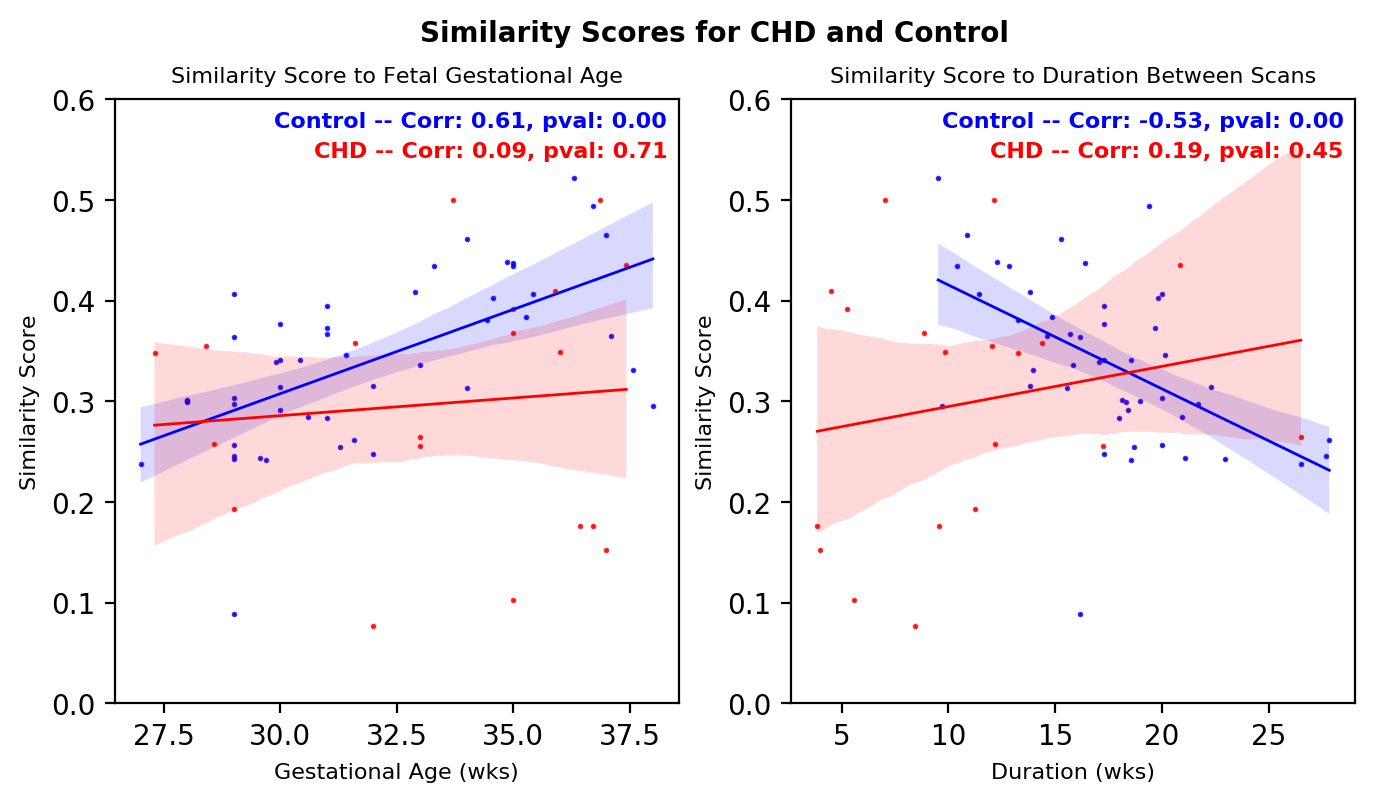

In [138]:
column = 'fetal_ga_wks'
res_chd = pearsonr(chd[column], (chd["similarity_value"]))
res_con = pearsonr(con[column], (con["similarity_value"]))


fig, axes = plt.subplots(1,2, facecolor = 'white', dpi = 200, figsize = (8,4))
fig.suptitle('Similarity Scores for CHD and Control', fontsize = 10, fontweight ='bold')
top = 0.98
step = 0.05
for enum,  (temp_df, color, res_object, chd_status) in enumerate(zip([con, chd], ['blue', 'red'], [res_con,res_chd], ['Control', 'CHD'])):
    sns.regplot(x=temp_df[column], y=temp_df['similarity_value'], color = color, scatter_kws = {'s':1}, line_kws = {'linewidth':1}, ax = axes[0])
    #axes[0].scatter(x=temp_df[column], y=temp_df['similarity_value'], color = color, s = 1)
    #axes[0].set_title(f'Correlation: {res_object[0]:>.2f}, p-value: {res_object[1]:>.2f}', fontsize = 8)
    y_loc = top-enum*step
    figure_text = f'{chd_status} -- Corr: {res_object[0]:>.2f}, pval: {res_object[1]:>.2f}' 
    axes[0].text(.98, y_loc, figure_text, color = color, fontweight ='bold', fontsize= 8, transform = axes[0].transAxes, ha = 'right', va = 'top')
    axes[0].set_xlabel('Gestational Age (wks)', fontsize = 8)
    axes[0].set_ylabel('Similarity Score', fontsize = 8)

column = 'time_duration_bt_fet_neo_wks'
res_chd = pearsonr(chd[column], (chd["similarity_value"]))
res_con = pearsonr(con[column], (con["similarity_value"]))
for enum,  (temp_df, color, res_object, chd_status) in enumerate(zip([con, chd], ['blue', 'red'], [res_con,res_chd], ['Control', 'CHD'])):
    sns.regplot(x=temp_df[column], y=temp_df['similarity_value'], color = color, scatter_kws = {'s':1}, line_kws = {'linewidth':1}, ax = axes[1])
    #axes[1].scatter(x=temp_df[column], y=temp_df['similarity_value'], color = color, s = 1)
    #axes[1].set_title(f'Correlation: {res_object[0]:>.2f}, p-value: {res_object[1]:>.2f}', fontsize = 8)
    y_loc = top-enum*step
    figure_text = f'{chd_status} -- Corr: {res_object[0]:>.2f}, pval: {res_object[1]:>.2f}'  
    axes[1].text(.98, y_loc, figure_text, color = color, fontweight ='bold', fontsize= 8, transform = axes[1].transAxes, ha = 'right', va = 'top')
    axes[1].set_xlabel('Duration (wks)', fontsize = 8)
    axes[1].set_ylabel('Similarity Score', fontsize = 8)
    
axes[0].set_ylim(0, 0.6)   
axes[1].set_ylim(0, 0.6)  
axes[0].set_title('Similarity Score to Fetal Gestational Age', fontsize = 8)
axes[1].set_title('Similarity Score to Duration Between Scans', fontsize = 8)
figure_dir = '/data/figures'
os.makedirs(figure_dir, exist_ok = True)


figure_title = 'mult_fig_chd_con.png'
save_path = os.path.join(figure_dir, figure_title)

plt.savefig(save_path, bbox_inches = 'tight', dpi = fig.dpi)
plt.show()

In [99]:
mannwhitneyu(chd["similarity_value"], con["similarity_value"])

MannwhitneyuResult(statistic=386.0, pvalue=0.1668292971000488)

In [100]:
ttest_ind(chd["similarity_value"], con["similarity_value"])

Ttest_indResult(statistic=-1.5545059260234357, pvalue=0.12491966775912786)